In [1]:
import math
from scipy import signal
from PIL import Image
import numpy
from numpy import *
from matplotlib import pyplot as plt
from pylab import *
import cv2
import random

/usr/local/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def gmask (x,y,s): # the function for gaussian filter
    gmask = numpy.exp(-((x**2) + (y**2))//2//s**2)
    return gmask

size  = 2
s = 1.5
G = [] # Gaussian Kernel
for i in range(-size,size+1):
    G.append(gmask(i,0,s)) # equating y to 0 since we need a 1D matrix

In [3]:
def DoLow (I): # the function down samples the intput image by 2
    '''Algorithm: For an input image of size rxc
           1) Apply x mask
           2) Delete Alternate Columns
           3) Apply y mask
           4) delete alternate rows
           The ouput image is of size (r//2)x(c//2)'''
    #========= Applying X mask ====================
    '''
    Ix = []
    for i in range(len(I[:,0])):
	Ix.extend([signal.convolve(I[i,:],G,'same')]) # Ix*Gx = Ix
    Ix = array(matrix(Ix))
    '''
    #========selecting alternate columns===========
    Ix = I
    Ix = Ix[:,::2]
    #========= Applying Y mask ====================
    '''
    Ixy = []
    for i in range(len(Ix[0,:])):
	Ixy.extend([signal.convolve(Ix[:,i],G,'same')]) # Ix * Gy = Ixy
    Ixy = array(matrix(transpose(Ixy)))
    '''
    #========selecting alternate rows===========
    Ixy = Ix
    Ixy = Ixy[::2,:]
    return Ixy # Returning Ixy...

In [4]:
def DoHigh (I,G): # the function up samples the intput image by 2
    '''Algorithm: For an input image of size rxc
           1) Insert zero column on every alternate columns
           2) Apply x mask
           3) Insert zero row on every alternate rows
           4) Apply y mask
           The ouput image is of size (2r)x(2c)'''
    G = numpy.dot(2,G) # Doubing the Guassian kernel since we later use alternate rows and columns
    #=========== Inserting alternate columns of zeros ========
    newI = numpy.zeros(shape=(shape(I)[0],2*shape(I)[1]))
    newI[:, ::2] = I
    #========= Applying X mask ====================
    '''
    Ix = []
    for i in range(len(newI[:,0])):
	Ix.extend([signal.convolve(newI[i,:],G,'same')]) # newI*G ----> x direction
    Ix = array(matrix(Ix))
    '''
    #=========== Inserting alternate rows of zeros ========
    Ix = newI
    newI = numpy.zeros(shape=(2*shape(Ix)[0],shape(Ix)[1]))
    newI[::2] = Ix
    #========= Applying Y mask ====================
    Ixy = newI
    '''
    Ixy = []
    for i in range(len(newI[0,:])):
	Ixy.extend([signal.convolve(newI[:,i],G,'same')]) # Ixy
    Ixy = array(matrix(transpose(Ixy)))
    '''
    return Ixy # Return Ixy...

In [5]:
def lk1(H #Frame 1
        ,I # Frame 2
        ):
    '''
        This function implements the LK optical flow estimation algorithm with two frame data.
        We use this function to return the derivative and vector values for the current section so that it can be used iteratively in lksection function
        '''
    # First Derivative in X direction
    fx = signal.convolve2d(H,[[-0.25,0.25],[-0.25,0.25]],'same') + signal.convolve2d(I,[[-0.25,0.25],[-0.25,0.25]],'same')
    # First Derivative in Y direction
    fy = signal.convolve2d(H,[[-0.25,-0.25],[0.25,0.25]],'same') + signal.convolve2d(I,[[-0.25,-0.25],[0.25,0.25]],'same')
    # First Derivative in XY direction
    ft = signal.convolve2d(H,[[0.25,0.25],[0.25,0.25]],'same') + signal.convolve2d(I,[[-0.25,-0.25],[-0.25,-0.25]],'same')
    # Initializing the u and v arrays with non numbers so that we don't have to plot the irrelevant vectors later
    #u = numpy.nan * numpy.ones(shape=(len(fx[:,0]),len(fx[0,:])))
    #v = numpy.nan * numpy.ones(shape=(len(fx[:,0]),len(fx[0,:])))
    u = numpy.ones(shape=(len(fx[:,0]),len(fx[0,:])))
    v = numpy.ones(shape=(len(fx[:,0]),len(fx[0,:])))
    # Determining the good features
    gf = cv2.goodFeaturesToTrack(H # Input image
                                 ,10000 # max corners
                                 ,0.01 # lambda 1 (quality)
                                 ,10 # lambda 2 (quality)
                                 )

    # Calculating the u and v arrays for the good features obtained n the previous step.
    for a in gf:
        j,i = a.ravel()
        # calculating the derivatives for the neighbouring pixels
        # since we are using  a 3*3 window, we have 9 elements for each derivative.
        i = int(i)
        j = int(j)
        FX = ([fx[i-1,j-1],fx[i,j-1],fx[i-1,j-1],fx[i-1,j],fx[i,j],fx[i+1,j],fx[i-1,j+1],fx[i,j+1],fx[i+1,j-1]])
        FY = ([fy[i-1,j-1],fy[i,j-1],fy[i-1,j-1],fy[i-1,j],fy[i,j],fy[i+1,j],fy[i-1,j+1],fy[i,j+1],fy[i+1,j-1]])
        FT = ([ft[i-1,j-1],ft[i,j-1],ft[i-1,j-1],ft[i-1,j],ft[i,j],ft[i+1,j],ft[i-1,j+1],ft[i,j+1],ft[i+1,j-1]])
        # Using the minimum least squares solution approach
        A = (FX,FY)
        A = matrix(A)
        AT = array(matrix(A))
        A = array(numpy.matrix.transpose(A))
        #Psedudo Inverse
        U1 = numpy.dot(AT,A)
        U2 = numpy.linalg.pinv(U1)
        U3 = numpy.dot(U2,AT)
        (u[i,j],v[i,j]) = numpy.dot(U3,FT) # we have the vectors with minimized square error

    u = numpy.flipud(u)
    v = numpy.flipud(v)
    return u,v

In [73]:
def lksection (I1 # frame 1
               ,I2 # frame 2
               ,uin # u from previous level
               ,vin # v from previous level
               ):
    '''This function runs the LK Algorithm for the current section of pyramid iteratively.
    We take a window of 5x5 and move from left top corner to right bottom corner in order to calculate the vectors for that window.
    Once the whole image is done, we sum the vectors of current and previous levels.
    '''

    uin = numpy.round(uin)
    vin = numpy.round(vin)
    u = numpy.zeros(shape(I1));
    v = numpy.zeros(shape(I2));
    print(u.shape)

    count = 0
    for i in range (2,len(I1[:,0])-2):
        for j in range (2,len(I2[0,:])-2):
            i = int(i)
            j = int(j)
            I1current = I1[i-2:i+3,j-2:j+3] # picking 5x5 pixels at a time
            lri = (i-2)+vin[i,j] #Low Row Index of the selected window
            hri = (i+2)+vin[i,j] #High Row Index of the selected window
            lci = (j-2)+uin[i,j] #Low Column Index of the selected window
            hci = (j+2)+uin[i,j] #High Column Index of the selected window

            #============= 5 x 5 Window search ===============
            '''When the 5x5 window goes beyond the resolution of the concerned image
            we choose the ending 5x5 window for that image.
            '''
            if(lri < 0): # if the window goes towards the left of the image
                lri = 0
                hri = 4
            if(lci < 0): # if the window goes above the image
                lci = 0
                hci = 4
            if(hri > (len(I1[:,0]))-1): #if the window goes towards the right of the image
                lri = len(I1[:,0])-5
                hri = len(I1[:,0])-1
            if(hci > (len(I1[0,:]))-1): # if the window goes below the image
                lci = len(I1[0,:])-5
                hci = len(I1[0,:])-1
            if(numpy.isnan(lri)):
                lri = i-2
                hri = i+2
            if(numpy.isnan(lci)):
                lci = j-2
                hci = j+2
            
            hci = int(hci)
            hri = int(hri)
            lci = int(lci)
            lri = int(lri)

            #Selecting the same window for the second frame
            I2current = I2[lri:(hri+1),lci:(hci+1)]
            # Now applying LK for each window of the 2 images
            fx = signal.convolve2d(I1current,[[-0.25,0.25],[-0.25,0.25]],'same') + signal.convolve2d(I2current,[[-0.25,0.25],[-0.25,0.25]],'same')
            fy = signal.convolve2d(I1current,[[-0.25,-0.25],[0.25,0.25]],'same') + signal.convolve2d(I2current,[[-0.25,-0.25],[0.25,0.25]],'same')
            ft = signal.convolve2d(I1current,[[0.25,0.25],[0.25,0.25]],'same') + signal.convolve2d(I2current,[[-0.25,-0.25],[-0.25,-0.25]],'same')

            FX =numpy.transpose(fx[1:5,1:5])
            FY = numpy.transpose(fy[1:5,1:5])
            FT = numpy.transpose(ft[1:5,1:5])

            FX = FX.ravel()
            FY = FY.ravel()
            FT = FT.ravel()

            A = (FX,FY)
            A = matrix(A)
            AT = array(matrix(A))
            A = array(numpy.matrix.transpose(A))

            U1 = numpy.dot(AT,A)
            U2 = numpy.linalg.pinv(U1)
            U3 = numpy.dot(U2,AT)
            print(i)
            print(j)
            (u[i,j],v[i,j]) = numpy.dot(U3,FT)
            #print(numpy.dot(U3,FT))
            count = count+1

    u = u+uin
    v = v+vin
    print(u.shape)
    print(count)
    print(u)
    # Taking the reciprocal of the condition number for A
    c = numpy.mat(transpose(A))*numpy.mat(A)
    c = 1.0//(linalg.cond(c))
    return u,v,c

In [74]:
def runproglk (I1,
               I2,
               iternum, # Number of iterations per level -- we are using 3
               nlev # Number of levels -- we are using 3
               ):
    I1 = array(Image.open(I1).convert('L')) # read the second input frame
    I2 = array(Image.open(I2).convert('L')) # read the second input frame
    ''' The function uses all the above defined function to implement LK algorithm in a multi-resolution Gaussian pyramid
    framework. We use the following :
    window size of 3x3
    Pyramid size = 3 levels
    Starting from the lower most level, at each level we use the iterative LK algorithm and then warp and upsample it so that it can be used for the next level.
    '''
    p1=numpy.empty((len(I1[:,0]),len(I1[0,:]),nlev)) # creating 3d array with different levels for frame 1
    p2=numpy.empty((len(I2[:,0]),len(I2[0,:]),nlev)) # creating 3d array with different levels for frame 2
    p1[:,:,0] = I1 # assign values for Highest level
    p2[:,:,0] = I2 # assign values for Highest level
    '''
    p[:,:,0] ---> Level 2 ---> Highest resolution
    p[:,:,2] ---> Level 0 ---> Least resolution
    '''
    # Defining the lower levels
    for i in range(1,nlev):
        I1 = DoLow(I1)
        I2 = DoLow(I2)
        p1[0:int((len(I1[:,0]))),0:int((len(I1[0,:]))),i] = I1
        p2[0:int((len(I2[:,0]))),0:int((len(I2[0,:]))),i] = I2

    #===================== level 0 - Base====================
    l0I1 = p1[0:int((len(p1[:,0])//4)),0:int((len(p1[0,:])//4)),2]
    l0I2 = p2[0:int((len(p2[:,0])//4)),0:int((len(p2[0,:])//4)),2]
    (u,v)= lk1(I1,I2)
    #============= Iterative LK for that section============
    for j in range(1,iternum+1):
        (u,v,c) = lksection (l0I1,l0I2,u,v)
    #============= Store U and V values ===================
    ul0 = u
    vl0 = v
    Il0 = l0I1
    ul0[numpy.where(ul0 == 0)] = nan
    vl0[numpy.where(vl0 == 0)] = nan
    #====================Level 1===================
    k = 1
    ue = DoHigh (u,G)
    ve = DoHigh (v,G)
    I1current = p1[0:(len(p1[:,0])//(2**(nlev-k-1))),0:(len(p1[0,:])//(2**(nlev-k-1))),nlev-k-1]
    I2current = p2[0:(len(p2[:,0])//(2**(nlev-k-1))),0:(len(p2[0,:])//(2**(nlev-k-1))),nlev-k-1]
    (u,v,c) = lksection (I1current,I2current,ue,ve)
    #========== Iterative LK for that section ===========
    for l in range(1,iternum+1):
        (u,v,c) = lksection (I1current,I2current,ue,ve)
    #============= Store U and V values ===================
    ul1 = u
    vl1 = v
    Il1 = I1current
    ul1[numpy.where(ul1 == 0)] = nan
    vl1[numpy.where(vl1 == 0)] = nan
    #====================Level 2=========================
    k = 2
    ue = DoHigh (u,G)
    ve = DoHigh (v,G)
    I1current = p1[0:(len(p1[:,0])//(2**(nlev-k-1))),0:(len(p1[0,:])//(2**(nlev-k-1))),nlev-k-1]
    I2current = p2[0:(len(p2[:,0])//(2**(nlev-k-1))),0:(len(p2[0,:])//(2**(nlev-k-1))),nlev-k-1]
    (u,v,c) = lksection (I1current,I2current,ue,ve)
    #========== Iterative LK for that section ===========
    for l in range(1,iternum+1):
        (u,v,c) = lksection (I1current,I2current,ue,ve)
    #============= Store U and V values ===================
    ul2 = u
    vl2 = v
    Il2 = I1current
    
    '''
    ul2[numpy.where(ul2 == 0)] = nan
    #vl2[numpy.where(vl2 == 0)] = nan
    #======= Pick Random color for vector plot========
    colors = "bgrcmykw"
    color_index = random.randrange(0,8)
    c=colors[color_index]
    #======= Plotting Level 0========
    plt.figure()
    plt.imshow(Il0,cmap = cm.gray)
    plt.title('Level 0 - Base level')
    quiver(ul0,vl0,color = c)
    #======= Plotting Level 1========
    c=colors[color_index]
    plt.figure()
    plt.imshow(Il1,cmap = cm.gray)
    plt.title('Level 1')
    quiver(ul1,vl1,color = c)
    #======= Plotting Level 2========
    c=colors[color_index]
    plt.figure()
    plt.imshow(Il2,cmap = cm.gray)
    plt.title('Level 2')
    quiver(ul2,vl2,color = c)
    show()
    '''
    
    
    #======= Plotting Final ========
    #u_fin = DoHigh(DoHigh (ul0,G),G) +DoHigh (ul1,G) + ul2 
    #v_fin = DoHigh(DoHigh (vl0,G),G) +DoHigh (vl1,G) + vl2 
    
    #c=colors[color_index]
    #plt.figure()
    #plt.imshow(Il2,cmap = cm.gray)
    #plt.title('Final')
    #quiver(u_fin,v_fin,color = c)
    #show()

    return(ul0,vl0,Il0,ul1,vl1,Il1,ul2,vl2,Il2)
'''
Since this program takes a lot of time to run.
Uncomment one of the three lines below to implement Lucas-Kanade optical flow estimation algorithm in a multi-resolution Gaussian pyramid
framework for the required pair of images
########################################## Run the Program for one pair of images at a time ######################################################
'''

'\nSince this program takes a lot of time to run.\nUncomment one of the three lines below to implement Lucas-Kanade optical flow estimation algorithm in a multi-resolution Gaussian pyramid\nframework for the required pair of images\n########################################## Run the Program for one pair of images at a time ######################################################\n'

In [75]:
numpy.set_printoptions(threshold=sys.maxsize)

In [76]:
prevImg= "dataset/other-data-color/RubberWhale/frame10.png"
nextImg= "dataset/other-data-color/RubberWhale/frame11.png"
(ul01,vl01,Il01,ul11,vl11,Il11,ul21,vl21,Il21) = runproglk(prevImg,nextImg,3,3)

(97, 146)
2
2
2
3
2
4
2
5
2
6
2
7
2
8
2
9
2
10
2
11
2
12
2
13
2
14
2
15
2
16
2
17
2
18
2
19
2
20
2
21
2
22
2
23
2
24
2
25
2
26
2
27
2
28
2
29
2
30
2
31
2
32
2
33
2
34
2
35
2
36
2
37
2
38
2
39
2
40
2
41
2
42
2
43
2
44
2
45
2
46
2
47
2
48
2
49
2
50
2
51
2
52
2
53
2
54
2
55
2
56
2
57
2
58
2
59
2
60
2
61
2
62
2
63
2
64
2
65
2
66
2
67
2
68
2
69
2
70
2
71
2
72
2
73
2
74
2
75
2
76
2
77
2
78
2
79
2
80
2
81
2
82
2
83
2
84
2
85
2
86
2
87
2
88
2
89
2
90
2
91
2
92
2
93
2
94
2
95
2
96
2
97
2
98
2
99
2
100
2
101
2
102
2
103
2
104
2
105
2
106
2
107
2
108
2
109
2
110
2
111
2
112
2
113
2
114
2
115
2
116
2
117
2
118
2
119
2
120
2
121
2
122
2
123
2
124
2
125
2
126
2
127
2
128
2
129
2
130
2
131
2
132
2
133
2
134
2
135
2
136
2
137
2
138
2
139
2
140
2
141
2
142
2
143
3
2
3
3
3
4
3
5
3
6
3
7
3
8
3
9
3
10
3
11
3
12
3
13
3
14
3
15
3
16
3
17
3
18
3
19
3
20
3
21
3
22
3
23
3
24
3
25
3
26
3
27
3
28
3
29
3
30
3
31
3
32
3
33
3
34
3
35
3
36
3
37
3
38
3
39
3
40
3
41
3
42
3
43
3
44
3
45
3
46
3
47
3
48
3
49
3
50
3
51
3


12
138
12
139
12
140
12
141
12
142
12
143
13
2
13
3
13
4
13
5
13
6
13
7
13
8
13
9
13
10
13
11
13
12
13
13
13
14
13
15
13
16
13
17
13
18
13
19
13
20
13
21
13
22
13
23
13
24
13
25
13
26
13
27
13
28
13
29
13
30
13
31
13
32
13
33
13
34
13
35
13
36
13
37
13
38
13
39
13
40
13
41
13
42
13
43
13
44
13
45
13
46
13
47
13
48
13
49
13
50
13
51
13
52
13
53
13
54
13
55
13
56
13
57
13
58
13
59
13
60
13
61
13
62
13
63
13
64
13
65
13
66
13
67
13
68
13
69
13
70
13
71
13
72
13
73
13
74
13
75
13
76
13
77
13
78
13
79
13
80
13
81
13
82
13
83
13
84
13
85
13
86
13
87
13
88
13
89
13
90
13
91
13
92
13
93
13
94
13
95
13
96
13
97
13
98
13
99
13
100
13
101
13
102
13
103
13
104
13
105
13
106
13
107
13
108
13
109
13
110
13
111
13
112
13
113
13
114
13
115
13
116
13
117
13
118
13
119
13
120
13
121
13
122
13
123
13
124
13
125
13
126
13
127
13
128
13
129
13
130
13
131
13
132
13
133
13
134
13
135
13
136
13
137
13
138
13
139
13
140
13
141
13
142
13
143
14
2
14
3
14
4
14
5
14
6
14
7
14
8
14
9
14
10
14
11
14
12
14
13
14
14


23
129
23
130
23
131
23
132
23
133
23
134
23
135
23
136
23
137
23
138
23
139
23
140
23
141
23
142
23
143
24
2
24
3
24
4
24
5
24
6
24
7
24
8
24
9
24
10
24
11
24
12
24
13
24
14
24
15
24
16
24
17
24
18
24
19
24
20
24
21
24
22
24
23
24
24
24
25
24
26
24
27
24
28
24
29
24
30
24
31
24
32
24
33
24
34
24
35
24
36
24
37
24
38
24
39
24
40
24
41
24
42
24
43
24
44
24
45
24
46
24
47
24
48
24
49
24
50
24
51
24
52
24
53
24
54
24
55
24
56
24
57
24
58
24
59
24
60
24
61
24
62
24
63
24
64
24
65
24
66
24
67
24
68
24
69
24
70
24
71
24
72
24
73
24
74
24
75
24
76
24
77
24
78
24
79
24
80
24
81
24
82
24
83
24
84
24
85
24
86
24
87
24
88
24
89
24
90
24
91
24
92
24
93
24
94
24
95
24
96
24
97
24
98
24
99
24
100
24
101
24
102
24
103
24
104
24
105
24
106
24
107
24
108
24
109
24
110
24
111
24
112
24
113
24
114
24
115
24
116
24
117
24
118
24
119
24
120
24
121
24
122
24
123
24
124
24
125
24
126
24
127
24
128
24
129
24
130
24
131
24
132
24
133
24
134
24
135
24
136
24
137
24
138
24
139
24
140
24
141
24
142
24
143
25
2
25

8
35
9
35
10
35
11
35
12
35
13
35
14
35
15
35
16
35
17
35
18
35
19
35
20
35
21
35
22
35
23
35
24
35
25
35
26
35
27
35
28
35
29
35
30
35
31
35
32
35
33
35
34
35
35
35
36
35
37
35
38
35
39
35
40
35
41
35
42
35
43
35
44
35
45
35
46
35
47
35
48
35
49
35
50
35
51
35
52
35
53
35
54
35
55
35
56
35
57
35
58
35
59
35
60
35
61
35
62
35
63
35
64
35
65
35
66
35
67
35
68
35
69
35
70
35
71
35
72
35
73
35
74
35
75
35
76
35
77
35
78
35
79
35
80
35
81
35
82
35
83
35
84
35
85
35
86
35
87
35
88
35
89
35
90
35
91
35
92
35
93
35
94
35
95
35
96
35
97
35
98
35
99
35
100
35
101
35
102
35
103
35
104
35
105
35
106
35
107
35
108
35
109
35
110
35
111
35
112
35
113
35
114
35
115
35
116
35
117
35
118
35
119
35
120
35
121
35
122
35
123
35
124
35
125
35
126
35
127
35
128
35
129
35
130
35
131
35
132
35
133
35
134
35
135
35
136
35
137
35
138
35
139
35
140
35
141
35
142
35
143
36
2
36
3
36
4
36
5
36
6
36
7
36
8
36
9
36
10
36
11
36
12
36
13
36
14
36
15
36
16
36
17
36
18
36
19
36
20
36
21
36
22
36
23
36
24
36
25
36
26
36


44
114
44
115
44
116
44
117
44
118
44
119
44
120
44
121
44
122
44
123
44
124
44
125
44
126
44
127
44
128
44
129
44
130
44
131
44
132
44
133
44
134
44
135
44
136
44
137
44
138
44
139
44
140
44
141
44
142
44
143
45
2
45
3
45
4
45
5
45
6
45
7
45
8
45
9
45
10
45
11
45
12
45
13
45
14
45
15
45
16
45
17
45
18
45
19
45
20
45
21
45
22
45
23
45
24
45
25
45
26
45
27
45
28
45
29
45
30
45
31
45
32
45
33
45
34
45
35
45
36
45
37
45
38
45
39
45
40
45
41
45
42
45
43
45
44
45
45
45
46
45
47
45
48
45
49
45
50
45
51
45
52
45
53
45
54
45
55
45
56
45
57
45
58
45
59
45
60
45
61
45
62
45
63
45
64
45
65
45
66
45
67
45
68
45
69
45
70
45
71
45
72
45
73
45
74
45
75
45
76
45
77
45
78
45
79
45
80
45
81
45
82
45
83
45
84
45
85
45
86
45
87
45
88
45
89
45
90
45
91
45
92
45
93
45
94
45
95
45
96
45
97
45
98
45
99
45
100
45
101
45
102
45
103
45
104
45
105
45
106
45
107
45
108
45
109
45
110
45
111
45
112
45
113
45
114
45
115
45
116
45
117
45
118
45
119
45
120
45
121
45
122
45
123
45
124
45
125
45
126
45
127
45
128
45
129


55
67
55
68
55
69
55
70
55
71
55
72
55
73
55
74
55
75
55
76
55
77
55
78
55
79
55
80
55
81
55
82
55
83
55
84
55
85
55
86
55
87
55
88
55
89
55
90
55
91
55
92
55
93
55
94
55
95
55
96
55
97
55
98
55
99
55
100
55
101
55
102
55
103
55
104
55
105
55
106
55
107
55
108
55
109
55
110
55
111
55
112
55
113
55
114
55
115
55
116
55
117
55
118
55
119
55
120
55
121
55
122
55
123
55
124
55
125
55
126
55
127
55
128
55
129
55
130
55
131
55
132
55
133
55
134
55
135
55
136
55
137
55
138
55
139
55
140
55
141
55
142
55
143
56
2
56
3
56
4
56
5
56
6
56
7
56
8
56
9
56
10
56
11
56
12
56
13
56
14
56
15
56
16
56
17
56
18
56
19
56
20
56
21
56
22
56
23
56
24
56
25
56
26
56
27
56
28
56
29
56
30
56
31
56
32
56
33
56
34
56
35
56
36
56
37
56
38
56
39
56
40
56
41
56
42
56
43
56
44
56
45
56
46
56
47
56
48
56
49
56
50
56
51
56
52
56
53
56
54
56
55
56
56
56
57
56
58
56
59
56
60
56
61
56
62
56
63
56
64
56
65
56
66
56
67
56
68
56
69
56
70
56
71
56
72
56
73
56
74
56
75
56
76
56
77
56
78
56
79
56
80
56
81
56
82
56
83
56
84
56
8

67
75
67
76
67
77
67
78
67
79
67
80
67
81
67
82
67
83
67
84
67
85
67
86
67
87
67
88
67
89
67
90
67
91
67
92
67
93
67
94
67
95
67
96
67
97
67
98
67
99
67
100
67
101
67
102
67
103
67
104
67
105
67
106
67
107
67
108
67
109
67
110
67
111
67
112
67
113
67
114
67
115
67
116
67
117
67
118
67
119
67
120
67
121
67
122
67
123
67
124
67
125
67
126
67
127
67
128
67
129
67
130
67
131
67
132
67
133
67
134
67
135
67
136
67
137
67
138
67
139
67
140
67
141
67
142
67
143
68
2
68
3
68
4
68
5
68
6
68
7
68
8
68
9
68
10
68
11
68
12
68
13
68
14
68
15
68
16
68
17
68
18
68
19
68
20
68
21
68
22
68
23
68
24
68
25
68
26
68
27
68
28
68
29
68
30
68
31
68
32
68
33
68
34
68
35
68
36
68
37
68
38
68
39
68
40
68
41
68
42
68
43
68
44
68
45
68
46
68
47
68
48
68
49
68
50
68
51
68
52
68
53
68
54
68
55
68
56
68
57
68
58
68
59
68
60
68
61
68
62
68
63
68
64
68
65
68
66
68
67
68
68
68
69
68
70
68
71
68
72
68
73
68
74
68
75
68
76
68
77
68
78
68
79
68
80
68
81
68
82
68
83
68
84
68
85
68
86
68
87
68
88
68
89
68
90
68
91
68
92
68
9

78
12
78
13
78
14
78
15
78
16
78
17
78
18
78
19
78
20
78
21
78
22
78
23
78
24
78
25
78
26
78
27
78
28
78
29
78
30
78
31
78
32
78
33
78
34
78
35
78
36
78
37
78
38
78
39
78
40
78
41
78
42
78
43
78
44
78
45
78
46
78
47
78
48
78
49
78
50
78
51
78
52
78
53
78
54
78
55
78
56
78
57
78
58
78
59
78
60
78
61
78
62
78
63
78
64
78
65
78
66
78
67
78
68
78
69
78
70
78
71
78
72
78
73
78
74
78
75
78
76
78
77
78
78
78
79
78
80
78
81
78
82
78
83
78
84
78
85
78
86
78
87
78
88
78
89
78
90
78
91
78
92
78
93
78
94
78
95
78
96
78
97
78
98
78
99
78
100
78
101
78
102
78
103
78
104
78

KeyboardInterrupt: 

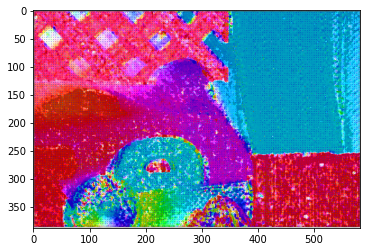

In [13]:
from src.representation.colorwhele import visualize_flow
img = visualize_flow(u = ul21, v = vl21)

In [8]:
def calc_all_flow():
    folders = ["Dimetrodon","DogDance","Grove2","Grove3","Hydrangea","MiniCooper","RubberWhale","Urban2","Urban3","Venus","Walking"]
    for folder in folders:
        prevImg= "dataset/other-data-color/"+folder+"/frame10.png"
        nextImg= "dataset/other-data-color/"+folder+"/frame11.png"
        (ul01,vl01,Il01,ul11,vl11,Il11,ul21,vl21,Il21) = runproglk(prevImg,nextImg,3,3)
        print(folder +": Succesfully calcualted optical flow")
        img = visualize_flow(u = ul21, v = vl21)
        cv2.imwrite("results/results-other-grey-pyramid/"+str(folder)+'.png', img)

In [9]:
calc_all_flow()

Dimetrodon: Succesfully calcualted optical flow


NameError: name 'visualize_flow' is not defined

In [36]:
cv2.imwrite("results/results-other-grey-pyramid/Dimetrodon.png", img)

error: OpenCV(4.6.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'


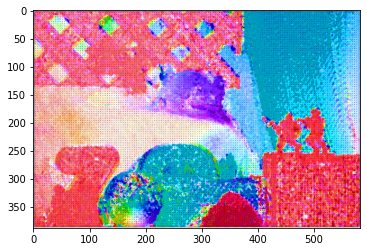

In [35]:
img = visualize_flow(u = ul21, v = vl21)